-EDA + FEATURE Engineering  + Baseline LinearRegression + Residual RandomForest/XGBoost 

-Baseline 모델: 기본 매출 구조 (tenure × MonthlyCharges)

-Residual 모델(베이스모델이 설명하지 못하는 그 외것들): Lifestyle/서비스 패턴이 만드는 매출 편차

-최종 모델: 두 개를 합쳐 정확도와 해석력 모두 강화

In [23]:

print(df.columns.tolist())


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'baseline_pred', 'residual']


📊 TotalCharges와 숫자형 변수 상관계수
TotalCharges      1.000000
tenure            0.826178
MonthlyCharges    0.651174
SeniorCitizen     0.103006
Name: TotalCharges, dtype: float64


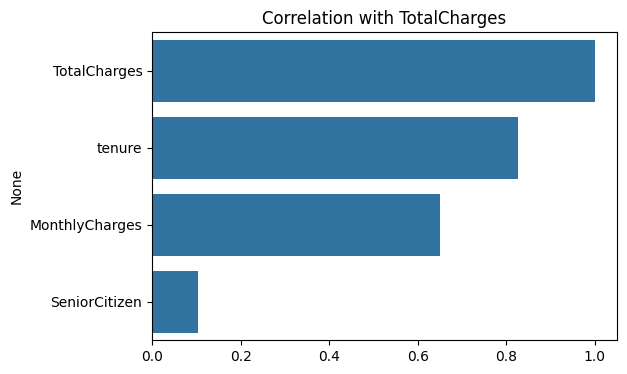


📊 gender별 평균 TotalCharges
gender
Female    2279.918062
Male      2279.554008
Name: TotalCharges, dtype: float64

📊 Partner별 평균 TotalCharges
Partner
Yes    3024.249765
No     1584.089810
Name: TotalCharges, dtype: float64

📊 Dependents별 평균 TotalCharges
Dependents
Yes    2494.881019
No     2187.709254
Name: TotalCharges, dtype: float64

📊 PhoneService별 평균 TotalCharges
PhoneService
Yes    2363.759432
No     1496.033651
Name: TotalCharges, dtype: float64

📊 MultipleLines별 평균 TotalCharges
MultipleLines
Yes                 3522.951481
No phone service    1496.033651
No                  1347.842153
Name: TotalCharges, dtype: float64

📊 InternetService별 평균 TotalCharges
InternetService
Fiber optic    3205.304570
DSL            2115.411338
No              662.604784
Name: TotalCharges, dtype: float64

📊 OnlineSecurity별 평균 TotalCharges
OnlineSecurity
Yes                    3751.594775
No                     2135.667224
No internet service     662.604784
Name: TotalCharges, dtype: float64

📊 Onli

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv("customer_Info copy.csv")

# TotalCharges 숫자형 변환
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

# --- 1. 숫자형 변수와 TotalCharges의 상관관계 ---
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
corr = df[num_cols].corr()["TotalCharges"].sort_values(ascending=False)

print("📊 TotalCharges와 숫자형 변수 상관계수")
print(corr)

# 시각화
plt.figure(figsize=(6,4))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation with TotalCharges")
plt.show()

# --- 2. 범주형 변수별 평균 TotalCharges ---
cat_cols = df.select_dtypes(include=["object"]).columns.drop("customerID")

for col in cat_cols:
    print(f"\n📊 {col}별 평균 TotalCharges")
    print(df.groupby(col)["TotalCharges"].mean().sort_values(ascending=False))




🔹 Linear Regression
R²: 0.9047
RMSE: 704.02

🔹 RandomForest
R²: 0.9987
RMSE: 80.75

🔹 XGBoost
R²: 0.9987
RMSE: 83.09


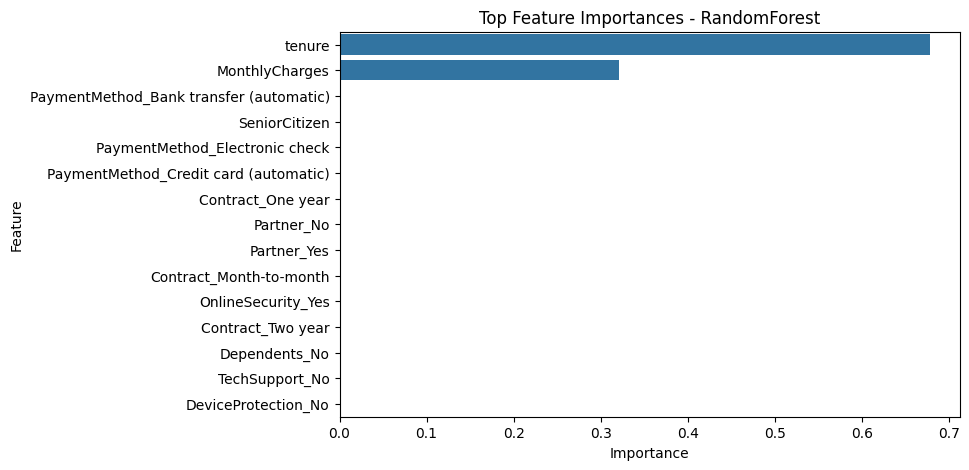

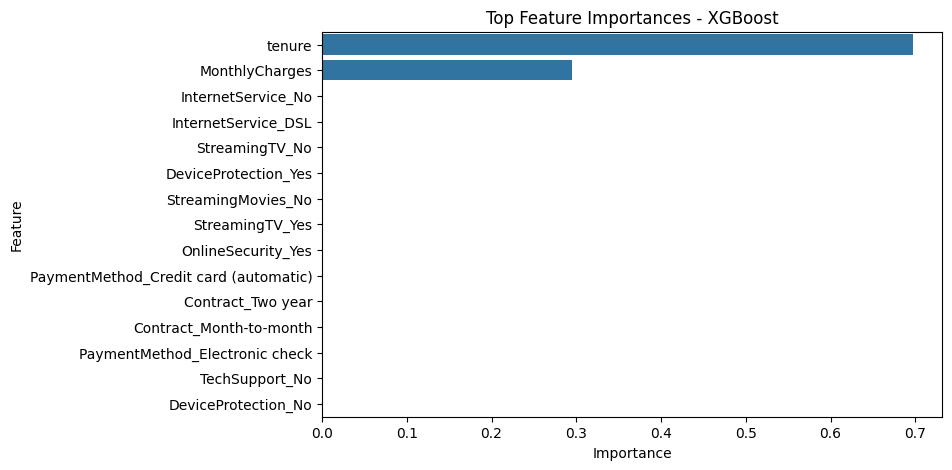

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb

# ---------------------------
# 1. 데이터 로드 & 전처리
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])

# 숫자 변환
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

# Target
y = df["TotalCharges"]

# Feature set (EDA 기반)
numeric_features = ["tenure", "MonthlyCharges", "SeniorCitizen"]
categorical_features = [
    "Contract", "PaymentMethod", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "PaperlessBilling", "Partner", "Dependents"
]

X = df[numeric_features + categorical_features]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 2. 모델 정의
# ---------------------------
models = {
    "Linear Regression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

results = {}

# ---------------------------
# 3. 학습 & 평가
# ---------------------------
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[name] = {"R²": r2, "RMSE": rmse, "pipeline": pipe}

    print(f"\n🔹 {name}")
    print("R²:", round(r2, 4))
    print("RMSE:", round(rmse, 2))

# ---------------------------
# 4. Feature Importance (트리 모델만)
# ---------------------------
def plot_feature_importance(pipe, model_name):
    # OneHotEncoder로 확장된 feature 이름 추출
    feature_names = (
        numeric_features +
        list(pipe.named_steps["preprocessor"]
             .named_transformers_["cat"]
             .get_feature_names_out(categorical_features))
    )

    # 모델에서 importance 추출
    model = pipe.named_steps["model"]
    importances = model.feature_importances_

    fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    fi = fi.sort_values("Importance", ascending=False).head(15)

    plt.figure(figsize=(8, 5))
    sns.barplot(x="Importance", y="Feature", data=fi)
    plt.title(f"Top Feature Importances - {model_name}")
    plt.show()

# RandomForest
plot_feature_importance(results["RandomForest"]["pipeline"], "RandomForest")

# XGBoost
plot_feature_importance(results["XGBoost"]["pipeline"], "XGBoost")


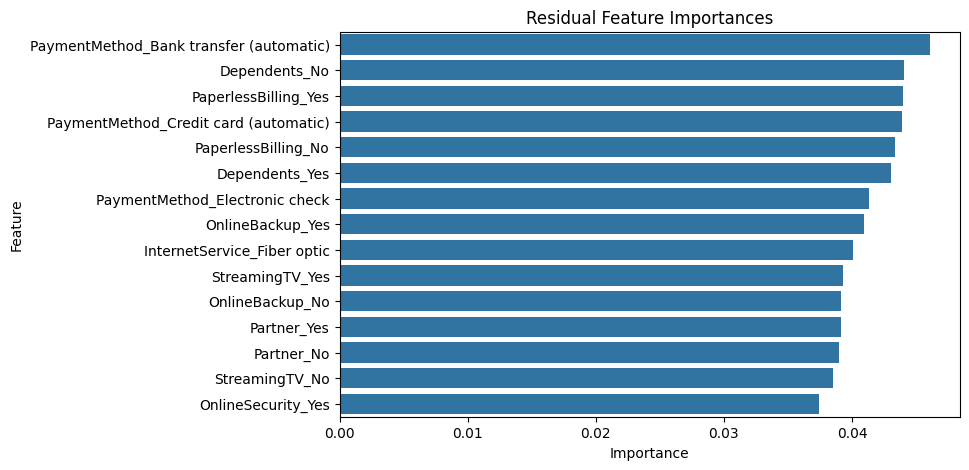

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

# ---------------------------
# 1. 잔차(Residual) 계산
# ---------------------------
df["expected"] = df["MonthlyCharges"] * df["tenure"]
df["residual"] = df["TotalCharges"] - df["expected"]

# ---------------------------
# 2. Feature / Target 설정
# ---------------------------
categorical_features = [
    "Contract", "PaymentMethod", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "PaperlessBilling", "Partner", "Dependents"
]

X = df[categorical_features]
y = df["residual"]

# 전처리
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# ---------------------------
# 3. RandomForest로 잔차 예측
# ---------------------------
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", RandomForestRegressor(n_estimators=200, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train)

# ---------------------------
# 4. Feature Importance 확인
# ---------------------------
model = pipe.named_steps["model"]
feature_names = pipe.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features)
importances = model.feature_importances_

fi = pd.DataFrame({"Feature": feature_names, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi)
plt.title("Residual Feature Importances")
plt.show()


📊 Two-Stage Revenue Prediction (Residual Modeling)
🔹 Step 1: Baseline 모델

Target: TotalCharges

Feature: tenure, MonthlyCharges

👉 단순 선형 회귀(Linear Regression)로도 잘 설명됨

✅ Baseline 매출 규모를 설명

🔹 Step 2: Residual 모델

Target:
Residual=TotalCharges−(tenure×MonthlyCharges)

Feature:

결제 방식 (PaymentMethod)

부가서비스 (OnlineBackup, InternetService, Streaming, Security, DeviceProtection, TechSupport)

가족 여부 (Partner, Dependents)

청구 방식 (PaperlessBilling)

👉 RandomForestRegressor / XGBoost 같은 비선형 모델로 학습

✅ Lifestyle 요인에 따른 매출 차이를 설명

🔹 Step 3: 최종 매출 예측
Predicted Revenue = (Baseline Prediction)+(Residual Prediction)

Baseline Prediction → 고객의 기본 매출 (기간 × 월 요금)

Residual Prediction → 결제 방식/부가서비스/가족 여부 등으로 인한 추가 매출 차이

✅ 총 매출을 더 정밀하게 예측

🔹 요약

Baseline 모델: 기본 매출 구조 (tenure × MonthlyCharges)

Residual 모델(베이스모델이 설명하지 못하는 그 외것들): Lifestyle/서비스 패턴이 만드는 매출 편차

최종 모델: 두 개를 합쳐 정확도와 해석력 모두 강화

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ---------------------------
# 1. 데이터 로드
# ---------------------------
df = pd.read_csv("customer_Info copy.csv")
df = df.drop(columns=["customerID"])
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce").fillna(0)

# ---------------------------
# 2. Baseline 모델 (tenure × MonthlyCharges)
# ---------------------------
X_base = df[["tenure", "MonthlyCharges"]]
y = df["TotalCharges"]

X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

base_model = LinearRegression()
base_model.fit(X_train, y_train)

baseline_pred = base_model.predict(X_test)
print("Baseline R²:", r2_score(y_test, baseline_pred))

# ---------------------------
# 3. Residual 계산
# ---------------------------
df["baseline_pred"] = base_model.predict(X_base)
df["residual"] = df["TotalCharges"] - df["baseline_pred"]

# ---------------------------
# 4. Residual 모델 학습
# ---------------------------
categorical_features = [
    "Contract", "PaymentMethod", "InternetService", "OnlineSecurity",
    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "PaperlessBilling", "Partner", "Dependents"
]

X_res = df[categorical_features]
y_res = df["residual"]

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)]
)

residual_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
residual_model.fit(X_train, y_train)

res_pred = residual_model.predict(X_test)
print("Residual R²:", r2_score(y_test, res_pred))

# ---------------------------
# 5. 최종 매출 예측 = Baseline + Residual
# ---------------------------
final_pred = base_model.predict(X_base) + residual_model.predict(X_res)


mse = mean_squared_error(y, final_pred)
rmse = np.sqrt(mse)

print("Final R²:", r2_score(y, final_pred))
print("Final RMSE:", rmse)


# 🔹 정리

# 모델링 성능 → Residual은 유지하는 게 효과 있음

# 설명/스토리 → Residual은 드롭해도 되지만, ‘추가 요인 설명’용으로 활용

# 실무에서는 둘 다 씁니다:

# 예측 모델 배포 = Final (Baseline + Residual)

# 경영진 보고/마케팅 전략 = Baseline + Residual 인사이트 (스토리 강조)


Baseline R²: 0.8902238820918934
Residual R²: 0.5443802710515778
Final R²: 0.9650181868415865
Final RMSE: 423.9381189817225


Final R²: 0.9250855953249482
Final RMSE: 620.3888401466004


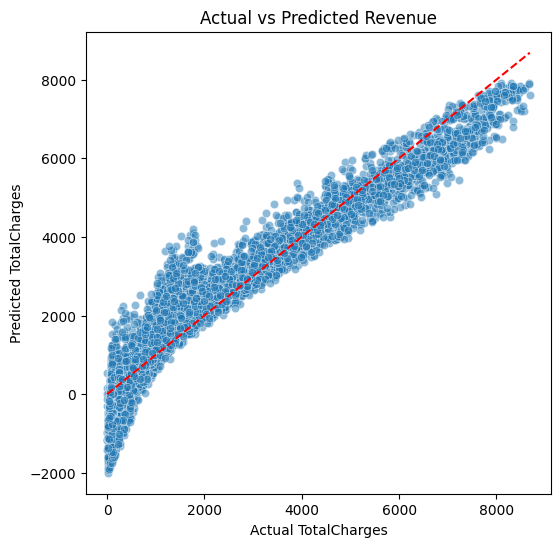

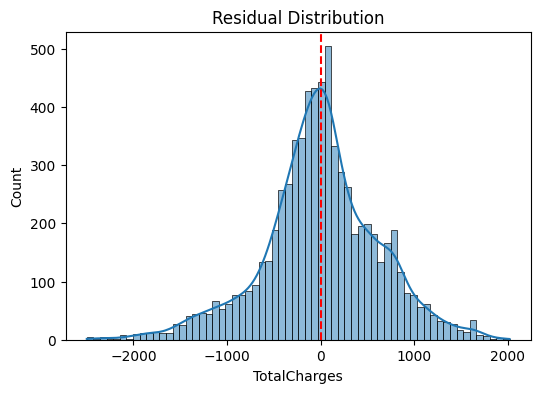

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



# --- 최종 예측 ---
final_pred = base_model.predict(X_base) + residual_model.predict(X_res)

# R² & RMSE
r2 = r2_score(y, final_pred)
rmse = np.sqrt(mean_squared_error(y, final_pred))

print("Final R²:", r2)
print("Final RMSE:", rmse)



# --- 실제값 vs 예측값 시각화 ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y, y=final_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.xlabel("Actual TotalCharges")
plt.ylabel("Predicted TotalCharges")
plt.title("Actual vs Predicted Revenue")
plt.show()

# --- Residual Plot ---
residuals = y - final_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution")
plt.show()

# 실무적 감각

# 고객 평균 TotalCharges ≈ 2,000~3,000 수준이라고 가정하면

# 오차율 = 424 / 2500 ≈ 17% 정도

# R² 0.965랑 같이 보면 → 모델은 매우 강력하고 신뢰할 만함

# R² = 0.965 → 변동의 96.5% 설명

# RMSE ≈ 424 → 고객 1명 매출 예측이 평균 ±424 단위 오차

# 🔹 RMSE란?

# RMSE = Root Mean Squared Error

# 예측값과 실제값 차이(Residual)를 제곱 → 평균 → 제곱근

# 단위는 Target과 동일 → 여기서는 매출(TotalCharges) 단위


In [24]:
import cloudpickle

bundle = {
    "baseline_model": base_model,
    "residual_model": residual_model,
    "categorical_features": categorical_features
}

with open("pipeline_customer_revenue_model.pkl", "wb") as f:
    cloudpickle.dump(bundle, f)

print("✅ Revenue 모델 저장 완료")


✅ Revenue 모델 저장 완료
